In [95]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

import jax.numpy as np
from jax.numpy import array as arr
from jax import lax, random
from jax.scipy.special import expit as logistic

import numpyro as pn
from numpyro import sample
from numpyro import deterministic
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.diagnostics import print_summary, hpdi

import warnings
pn.set_platform("cpu")
pn.set_host_device_count(4)

In [6]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
az.style.use("arviz-darkgrid")
plt.style.use("dark_background")
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(category.__name__, message)
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Wed Sep 07 2022

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

arviz     : 0.12.1
numpyro   : 0.10.1
pandas    : 1.4.4
jax       : 0.3.17
matplotlib: 3.5.3
sys       : 3.10.6 | packaged by conda-forge | (main, Aug 22 2022, 20:38:29) [Clang 13.0.1 ]

Watermark: 2.3.1



In [150]:
def z(x):
    return (x - x.mean()) / x.std()
    
## for jax's RNG
def key_gen(seed = random.PRNGKey(8927)):
    def key():
        nonlocal seed
        seed, new_key = random.split(seed)
        return new_key
    return key

key = key_gen()

In [5]:
a = 3.5 ## intercept = mean morning wait time
b = -1.0 ## slope = diff btw morning and afternoon
sA = 1 ## sd intercept
sB = 0.5 ## sd slope
r = -0.7 ## correlation slope and intercept
Mu = arr([a, b])
svec = arr([sA, sB])
Rho = arr([[1,r],[r,1]]) ## correlation matrix
Sigma = np.diag(svec) @ Rho @ np.diag(svec) ## var-covar matrix
nCafes = 20

In [7]:
intercepts_slopes = dist.MultivariateNormal(Mu, Sigma).sample(key(), (nCafes,))

In [10]:
nVisits = 10
afternoon = np.tile(arr([0,1]), nVisits * nCafes // 2)
cafeId = np.repeat(np.arange(nCafes), nVisits)
muWait = intercepts_slopes[cafeId,0] + intercepts_slopes[cafeId,1] * afternoon
sWait = 0.5

In [32]:
obsWait = dist.Normal(muWait, sWait).sample(key())
d = pd.DataFrame({'cafe': cafeId, 'afternoon': afternoon, 'wait': obsWait})
d.head()

,cafe,afternoon,wait
0,0,0,3.342459
1,0,1,1.518795
2,0,0,3.167958
3,0,1,2.167953
4,0,0,2.849481


In [21]:
## LKJ generates n x n correlation matrix
x = dist.LKJ(2, concentration=2).sample(key(), (10000,))
x

DeviceArray([[[ 1.        , -0.4760558 ],
              [-0.4760558 ,  1.        ]],

             [[ 1.        ,  0.15355754],
              [ 0.15355754,  1.0000001 ]],

             [[ 1.        ,  0.74645585],
              [ 0.74645585,  1.        ]],

             ...,

             [[ 1.        ,  0.09583715],
              [ 0.09583715,  1.        ]],

             [[ 1.        , -0.51278263],
              [-0.51278263,  1.        ]],

             [[ 1.        , -0.5079404 ],
              [-0.5079404 ,  1.        ]]], dtype=float32)

<AxesSubplot:>

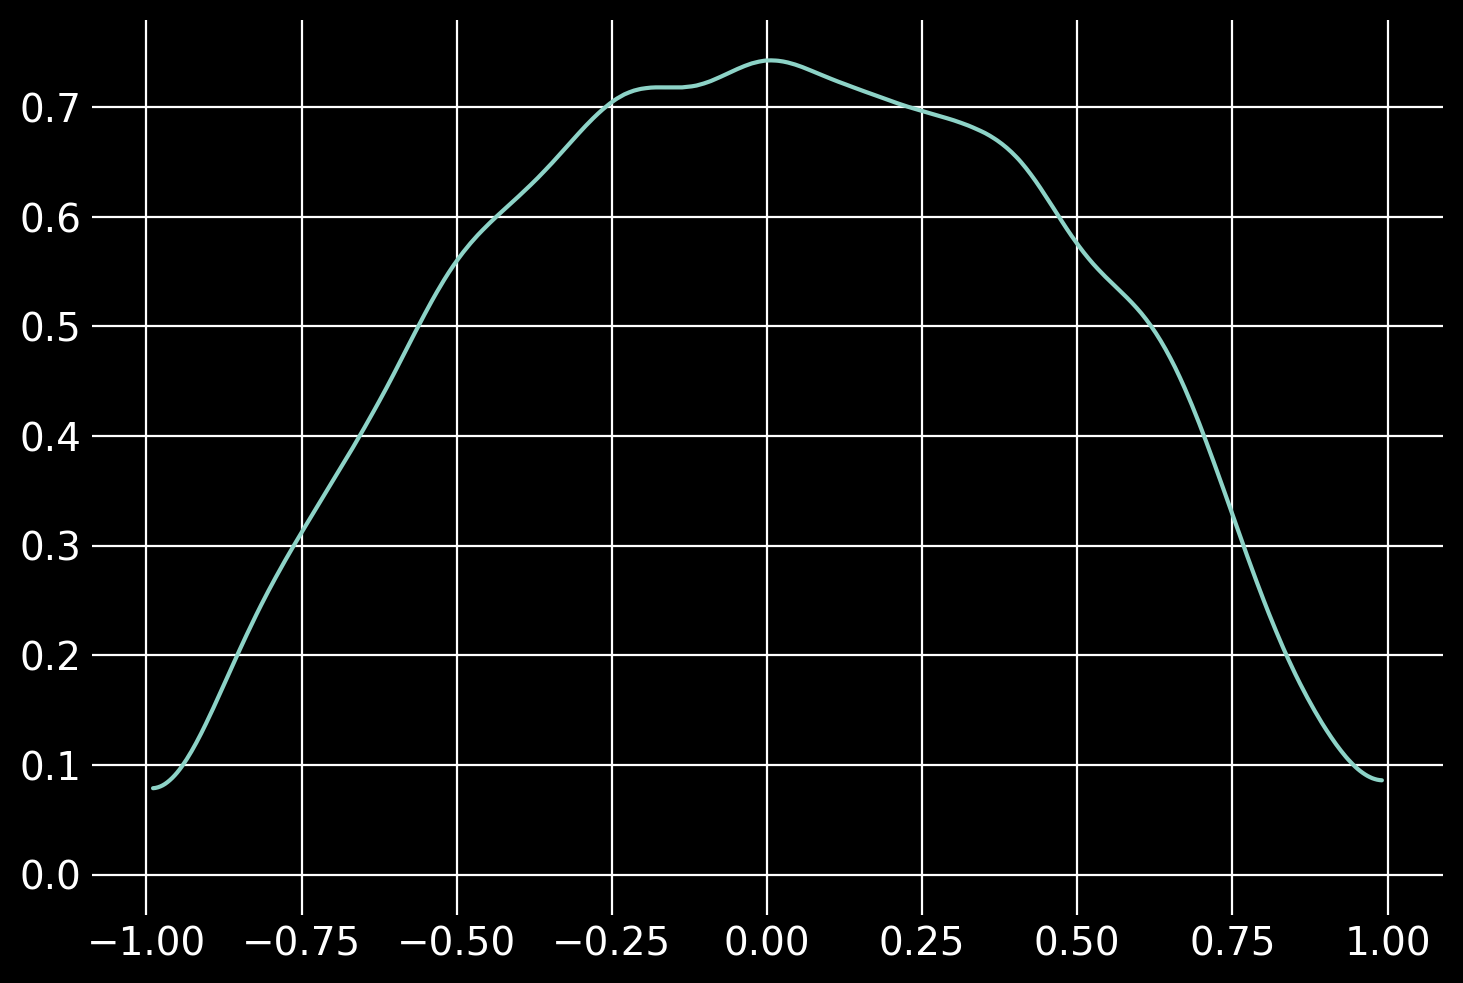

In [23]:
az.plot_kde(x[:, 0, 1])

In [ ]:
def model1(cafe, afternoon, wait):
    a = sample("a", dist.Normal(5, 2))
    b = sample("b", dist.Normal(-1, 0.5))
    Mu = np.stack([a,b])
    sa = sample("sa", dist.Exponential(1))
    sb = sample("sb", dist.Exponential(1))
    svec = np.stack([sa,sb])
    Rho = sample("Rho", dist.LKJ(2, 2))
    ## numpyro's mvnormal dist needs the var-covar matrix
    Sigma = np.diag(svec) @ Rho @ np.diag(svec) 
    ab = sample("ab", dist.MultivariateNormal(Mu, Sigma), sample_shape=(nCafes,) )
    muWait = deterministic("muWait", ab[cafe,0] + ab[cafe,1] * afternoon)
    sWait = sample("sWait", dist.Exponential(1))
    sample("wait", dist.Normal(muWait, sWait), obs=wait)

m1 = MCMC(NUTS(model1), num_warmup=500, num_samples=500, num_chains=4)
m1.run(key(), d.cafe.values, d.afternoon.values, d.wait.values)

In [52]:
az.summary(m1, var_names=['~ab','~muWait'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Rho[0, 0]",1.000,0.000,1.000,1.000,0.000,0.000,2000.0,2000.0,NaN
"Rho[0, 1]",-0.552,0.180,-0.859,-0.227,0.004,0.003,2071.0,1667.0,1.0
"Rho[1, 0]",-0.552,0.180,-0.859,-0.227,0.004,0.003,2071.0,1667.0,1.0
"Rho[1, 1]",1.000,0.000,1.000,1.000,0.000,0.000,1838.0,1964.0,1.0
a,3.338,0.192,2.969,3.680,0.004,0.003,2262.0,1280.0,1.0
b,-1.147,0.131,-1.379,-0.897,0.003,0.002,1654.0,1417.0,1.0
sWait,0.484,0.028,0.432,0.534,0.001,0.000,2391.0,1407.0,1.0
sa,0.847,0.145,0.592,1.109,0.003,0.002,2535.0,1166.0,1.0
sb,0.516,0.111,0.309,0.714,0.003,0.002,1438.0,1540.0,1.0


In [59]:
az.from_numpyro(m1)

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

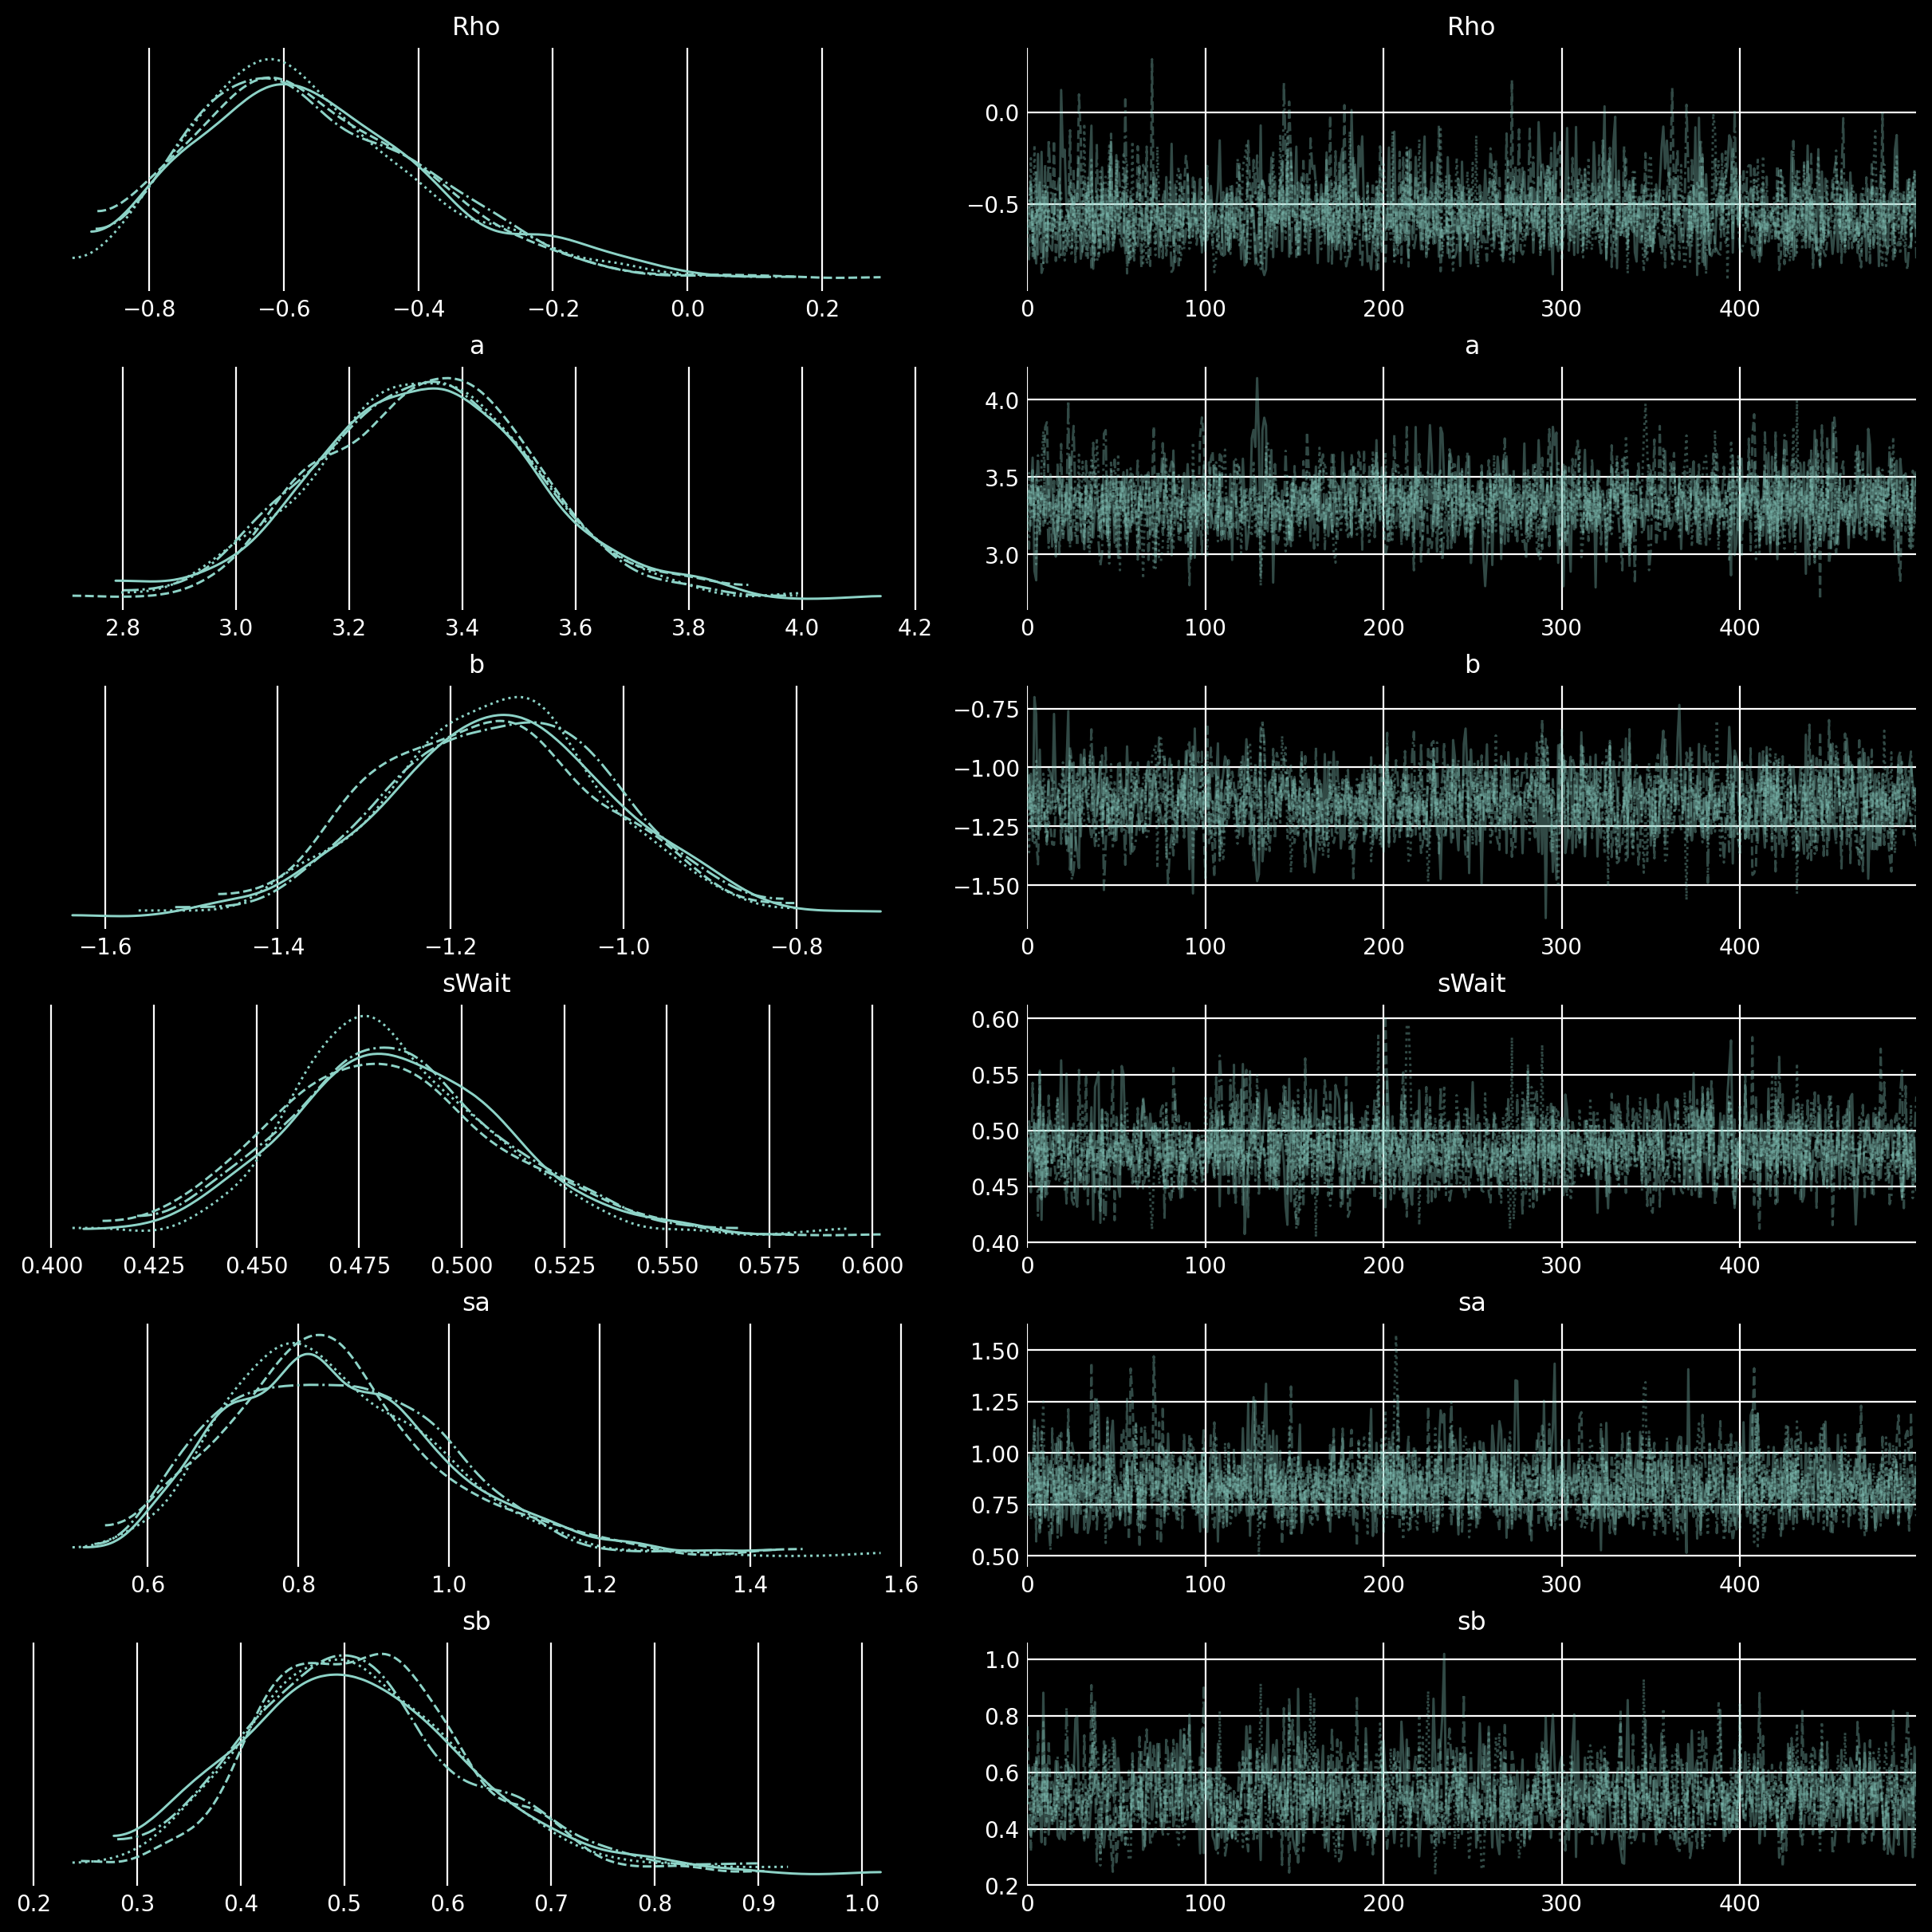

In [61]:
az.plot_trace(m1 , var_names=['~ab','~muWait'], coords={'Rho_dim_0':1, 'Rho_dim_1':0});

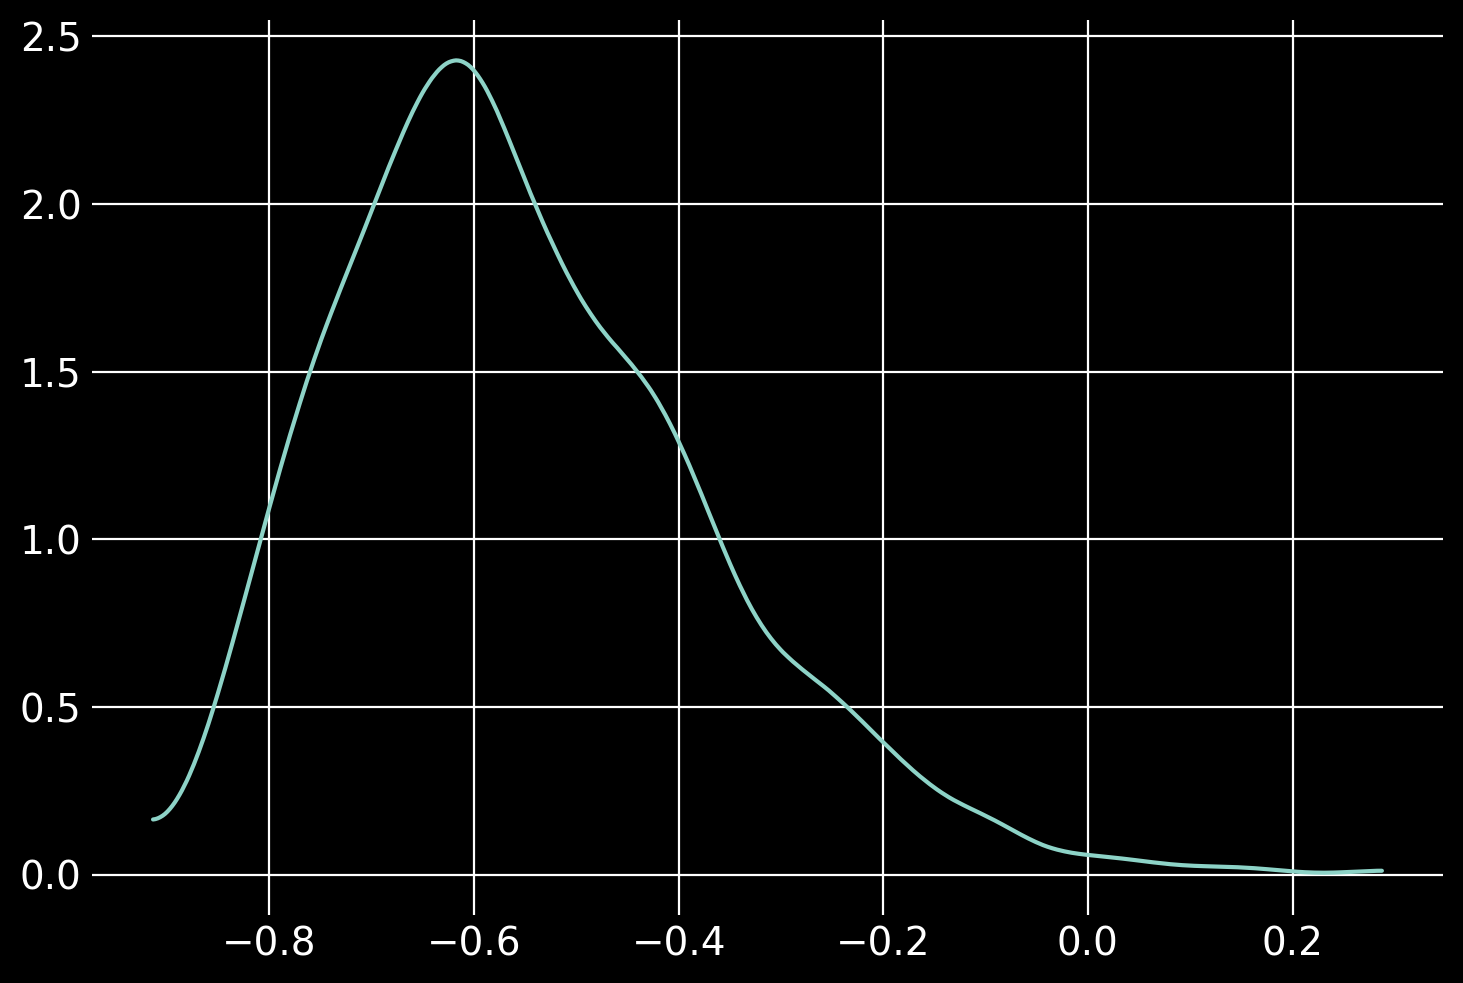

In [65]:
post1 = m1.get_samples()
az.plot_kde(post1['Rho'][:,0,1]);

In [77]:
obsMeans = d.groupby(['afternoon','cafe']).mean()
obsMeans.shape

(40, 1)

In [78]:
estMeans = post1['ab'].mean(0)
estMeans.shape

DeviceArray([3.0099602, 3.3074913, 2.725284 , 4.172341 , 3.5349462,
             3.2978938, 3.5608459, 3.523211 , 2.1605282, 5.0784135,
             4.3304906, 3.951721 , 3.2680705, 3.2876456, 2.644778 ,
             3.4584112, 3.7000241, 1.362395 , 2.7539914, 3.2529817],            dtype=float32)

In [79]:
obsA = obsMeans.loc[0,'wait'].values  # morning
obsB = obsMeans.loc[1,'wait'].values - obsA  # afternoon - morning
estA = estMeans[:,0] # intercepts
estB = estMeans[:,1] # slopes
obsMorning = obsA
obsAfternoon = obsA + obsB
estMorning = estA
estAfternoon = estA + estB

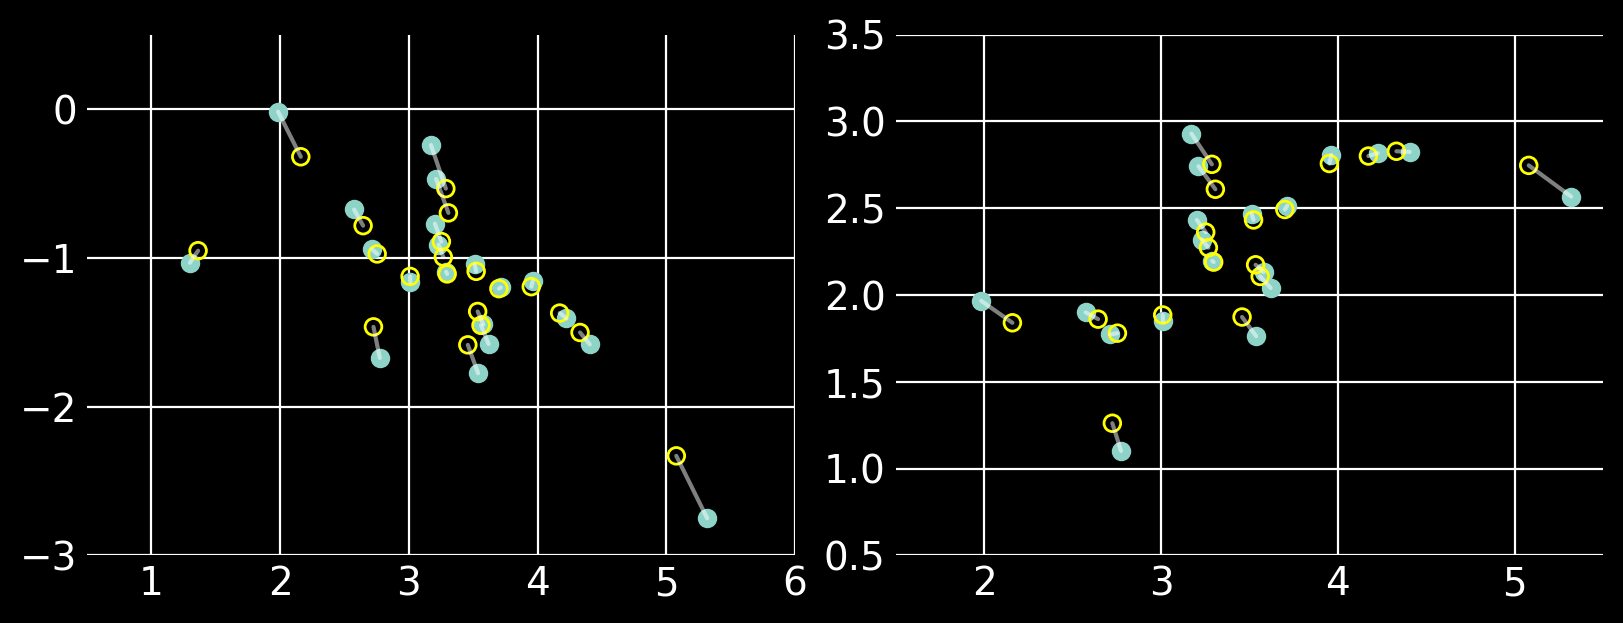

In [86]:
_, (ax,ax2) = plt.subplots(1,2,figsize=[8,3])
ax.set_xlim(0.5,6.0)
ax.set_ylim(-3.0,0.5)
ax.scatter(obsA, obsB)
ax.scatter(estA, estB, facecolors="none", edgecolors="yellow", lw=1, alpha=1.0)
ax.plot([obsA, estA], [obsB, estB], "w-", alpha=0.5);

ax2.set_xlim(1.5,5.5)
ax2.set_ylim(0.5,3.5)
ax2.scatter(obsMorning, obsAfternoon)
ax2.scatter(estMorning, estAfternoon, facecolors="none", edgecolors="yellow", lw=1, alpha=1.0)
ax2.plot([obsMorning, estMorning], [obsAfternoon, estAfternoon], "w-", alpha=0.5);

In [87]:
### 14.2
d = pd.read_csv("Data/chimpanzees.csv", sep=';')
d["actor"] -= 1
d["block"] -= 1
d["treatment"] = d["prosoc_left"] + 2*d["condition"]
d.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left,treatment
0,0,NaN,0,0,2,0,1,0,0
1,0,NaN,0,0,4,0,0,1,0
2,0,NaN,0,0,6,1,0,0,1
3,0,NaN,0,0,8,0,1,0,0
4,0,NaN,0,0,10,1,1,1,1


In [88]:
actor_idx, actors = pd.factorize(d["actor"])
treatment_idx, treatments = pd.factorize(d["treatment"])
block_idx, blocks = pd.factorize(d["block"])

$L \sim Binomial(1, p)$ : pull left with binomial probability p  

$ logit(p) = g_{tid} + a_{actor,tid} + b_{block,tid}$  
log-odds = treatment effect + separate actor effect for each treatment (interaction) + block-treatment interaction

$(a_{j,1..4}) \sim MVNormal((0..0), S_{actor})$  
the actor effects come from a shared distribution in which the 4 treatment responses are correlated

$(b_{j,1..4}) \sim MVNormal((0..0), S_{block})$  
likewise for the block effects

In [ ]:
dat = dict(pulled_left = d['pulled_left'].values,
        treatment = d['treatment'].values,
        actor = d['actor'].values,
        block_id = d['block'].values)

def model3(treatment, actor, block_id, pulled_left=None):
    ## 4 intercepts for treatment effect
    g = sample("g", dist.Normal(), sample_shape=(len(treatments),)) 
    ## all actor effects come from a shared distribution with these sd's (different sd for each treatment):
    sdA = sample("sdA", dist.Exponential(1), sample_shape=(len(treatments), )) 
    ## actor effect will be different for each treatment (actor x treatment interaction)
    ##   but those treatments are correlated across the board based on cholA
    ## can't specify sd in LKJChol, need to scale separately
    cholA = sample("cholA", dist.LKJCholesky(4,2)) 
    ## all blocks likewise correlated
    sdB = sample("sdB", dist.Exponential(1), sample_shape=(len(treatments), ))
    cholB = sample("cholB", dist.LKJCholesky(4,2))
    ## non-centered parameters; will be [treatments, actors]
    ### each actor will have a zA that's 4-d multivariate (treatments)
    ####  but below, those zA are multiplied by a shared var-covar matrix
    zA = sample("zA", dist.Normal(), sample_shape=(len(treatments), len(actors)))
    zB = sample("zB", dist.Normal(), sample_shape=(len(treatments), len(blocks)))
    ## chol scaled by sd, matrix-mult by Z
    a = deterministic("a", (sdA[...,None] * cholA) @ zA)
    b = deterministic("b", (sdB[...,None] * cholB) @ zB)
    p_logit = g[treatment] + a[treatment,actor] + b[treatment,block_id]
    # compute ordinary correlation matrixes from Cholesky factors
    deterministic("Rho_a", cholA @ cholA.T)
    deterministic("Rho_b", cholB @ cholB.T)
    deterministic("p", logistic(p_logit))
    sample("L", dist.Binomial(logits=p_logit), obs=pulled_left)

m3 = MCMC(NUTS(model3), num_warmup=500, num_samples=500, num_chains=4)
m3.run(key(), **dat)


In [92]:
m3.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
cholA[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
cholA[0,1]      0.00      0.00      0.00      0.00      0.00       nan       nan
cholA[0,2]      0.00      0.00      0.00      0.00      0.00       nan       nan
cholA[0,3]      0.00      0.00      0.00      0.00      0.00       nan       nan
cholA[1,0]      0.43      0.28      0.47      0.03      0.91   1385.25      1.00
cholA[1,1]      0.85      0.14      0.88      0.64      1.00   1188.80      1.00
cholA[1,2]      0.00      0.00      0.00      0.00      0.00       nan       nan
cholA[1,3]      0.00      0.00      0.00      0.00      0.00       nan       nan
cholA[2,0]      0.52      0.25      0.56      0.15      0.91   1249.24      1.00
cholA[2,1]      0.28      0.31      0.30     -0.23      0.78    929.12      1.00
cholA[2,2]      0.68      0.17      0.69      0.42      0.97   1301.47      1.00
cholA[2,3]      0.00      0

In [94]:
az.summary(m3, var_names=['g','sdA','sdB'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
g[0],0.202,0.496,-0.760,1.110,0.016,0.011,958.0,1243.0,1.01
g[1],0.637,0.399,-0.182,1.297,0.011,0.008,1340.0,1113.0,1.00
g[2],-0.043,0.592,-1.101,1.149,0.017,0.012,1267.0,1662.0,1.00
g[3],0.678,0.555,-0.412,1.642,0.015,0.011,1372.0,1173.0,1.01
sdA[0],1.377,0.474,0.604,2.230,0.015,0.010,1045.0,1270.0,1.00
sdA[1],0.901,0.410,0.308,1.660,0.012,0.008,1285.0,1169.0,1.00
sdA[2],1.861,0.585,0.901,2.953,0.014,0.010,1771.0,1524.0,1.00
sdA[3],1.590,0.593,0.580,2.672,0.015,0.011,1745.0,1474.0,1.00
sdB[0],0.401,0.332,0.001,1.006,0.010,0.007,1011.0,1004.0,1.00
sdB[1],0.426,0.354,0.001,1.017,0.011,0.008,782.0,912.0,1.00


In [105]:
## print_summary() expects grouped by chain
summary3 = m3.get_samples(group_by_chain=True)
pars3 = {k: summary3[k] for k in ['g', 'sdA', 'sdB']}
print_summary(pars3)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      g[0]      0.20      0.50      0.19     -0.60      1.04    942.34      1.01
      g[1]      0.64      0.40      0.65     -0.02      1.23   1284.79      1.00
      g[2]     -0.04      0.59     -0.06     -1.00      0.92   1255.07      1.00
      g[3]      0.68      0.55      0.68     -0.24      1.57   1330.71      1.01
    sdA[0]      1.38      0.47      1.29      0.69      2.08   1028.85      1.00
    sdA[1]      0.90      0.41      0.83      0.29      1.41   1201.21      1.00
    sdA[2]      1.86      0.58      1.76      0.98      2.74   1770.84      1.00
    sdA[3]      1.59      0.59      1.49      0.70      2.48   1588.47      1.00
    sdB[0]      0.40      0.33      0.33      0.00      0.84   1106.65      1.00
    sdB[1]      0.43      0.35      0.34      0.00      0.87    950.85      1.00
    sdB[2]      0.30      0.26      0.23      0.00      0.64   1842.79      1.00
    sdB[3]      0.49      0

In [116]:
post3 = m3.get_samples()
## by actor first, then by treatment
obs_meanL = d.groupby(['actor','treatment']).mean()['pulled_left'].values
## posterior predictive
d_pred = {'actor': np.repeat(np.arange(7),4), 'treatment':np.tile(np.arange(4),7), 'block_id':np.repeat(3,7*4)}
post_pred = Predictive(model3, post3)(key(), **d_pred)
post_pred['p'].shape


(2000, 28)

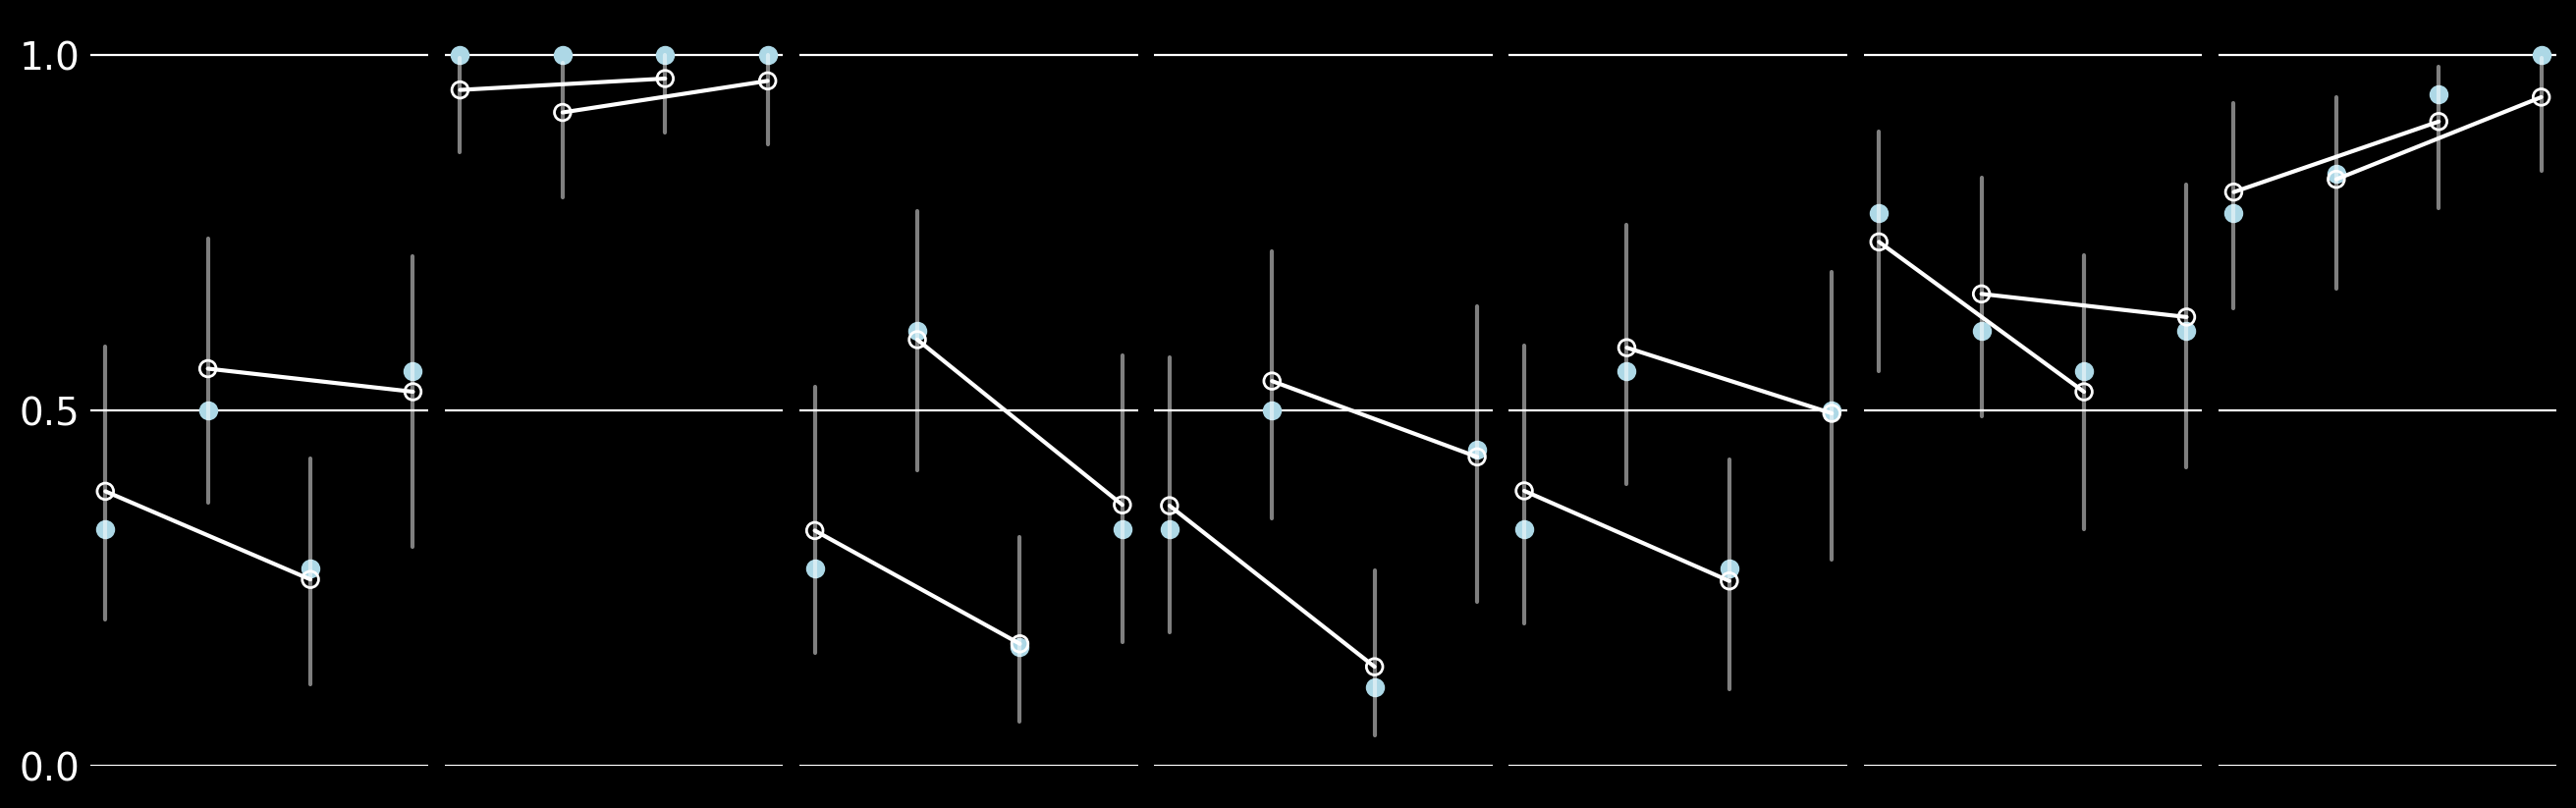

In [124]:
pred_meanL = post_pred['p'].mean(0)
pred_meanL_ci = np.percentile(post_pred['p'], q=arr([5.5, 94.5]), axis=0).T

_, ax = plt.subplots(1, 7, sharey=True, figsize=[13,4])
for i in range(7):
    ax[i].set_xticks([]); ax[i].set_ylim(0,1.05); ax[i].set_yticks([0,0.5,1])
    ax[i].scatter(np.arange(4), obs_meanL[i*4:i*4+4], color='lightblue')
    ax[i].scatter(np.arange(4), pred_meanL[i*4:i*4+4], color="none", edgecolor="w")
    ax[i].plot([0,2], [pred_meanL[i*4], pred_meanL[i*4+2]], color="w")
    ax[i].plot([1,3], [pred_meanL[i*4+1], pred_meanL[i*4+3]], color="w")
    for j in range (4):
        ax[i].plot([j,j], pred_meanL_ci[i*4+j], color='w', alpha=0.5)

In [170]:
## instrumental variables, multivariate output

## simulate effect of education (E) on wages (W)
n = 500
## set true effect to 0
bEW_true = 0.0
## unobserved confound U
U_sim = random.normal(key(), (n,))
## quarter of birth Q influences education
##  if it's not affected by the unobs confound(s)
##  and doesn't directly influence W, then it can
##  be used as a natural experiment modulating E
Q_sim = random.randint(key(), (n,), 1, 5) 
E_sim = U_sim + Q_sim + 1.0 * random.normal(key(), (n,))
W_sim = U_sim + bEW_true * E_sim + 1.0 * random.normal(key(), (n,))
dsim = {'W': z(W_sim), 'E': z(E_sim), 'Q': z(Q_sim)}
## causality:
##  Q -> E -> W,  Q -> E <- U -> W


In [183]:
def model6(E, Q, W):
    aW = sample("aW", dist.Normal(0, 0.2))
    aE = sample("aE", dist.Normal(0, 0.2))
    bEW = sample("bEW", dist.Normal(0, 0.5))
    bQE = sample("bQE", dist.Normal(0, 0.5))
    ## E -> W, Q -> E
    muW = aW + bEW * E
    muE = aE + bQE * Q
    Mu = np.stack([muW, muE], axis=1) ## note axis
    sd_WE = sample("sd_WE", dist.Exponential(1), sample_shape=(2, ))
    Rho = sample("Rho", dist.LKJ(2, 2))
    Sigma = np.outer(sd_WE, sd_WE) * Rho ## faster?
    sample("WE", dist.MultivariateNormal(Mu, Sigma), obs=np.stack([W, E], axis=1)) ## note axis

m6 = MCMC(NUTS(model6), num_warmup=500, num_samples=500, num_chains=4)
m6.run(key(), **dsim)

Compiling.. :   0%|          | 0/1000 [00:00<?, ?it/s]






Running chain 0:   0%|          | 0/1000 [00:04<?, ?it/s]

Running chain 3: 100%|██████████| 1000/1000 [00:04<00:00, 245.75it/s]


In [184]:
m6.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  Rho[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
  Rho[0,1]      0.46      0.06      0.46      0.37      0.56    880.85      1.00
  Rho[1,0]      0.46      0.06      0.46      0.37      0.56    880.85      1.00
  Rho[1,1]      1.00      0.00      1.00      1.00      1.00    426.59      1.00
        aE      0.00      0.03      0.00     -0.05      0.06   1642.50      1.00
        aW      0.00      0.04      0.00     -0.07      0.07   1760.84      1.00
       bEW      0.10      0.07      0.10     -0.02      0.21    898.43      1.00
       bQE      0.62      0.03      0.62      0.56      0.67   1590.39      1.00
  sd_WE[0]      0.97      0.04      0.96      0.90      1.03    971.65      1.00
  sd_WE[1]      0.79      0.02      0.79      0.75      0.83   2153.43      1.00

Number of divergences: 0


In [185]:
## 14.4 social relations model

d = pd.read_csv("Data/KosterLeckie.csv", sep=',')
d['hidA'] -= 1
d['hidB'] -= 1
d['did'] -= 1
nHouse = 25
nDyad = len(d['did'].unique())
d.head()

,hidA,hidB,did,giftsAB,giftsBA,offset,drel1,drel2,drel3,drel4,dlndist,dass,d0125
0,0,1,0,0,4,0.000,0,0,1,0,-2.790,0.000,0
1,0,2,1,6,31,-0.003,0,1,0,0,-2.817,0.044,0
2,0,3,2,2,5,-0.019,0,1,0,0,-1.886,0.025,0
3,0,4,3,4,2,0.000,0,1,0,0,-1.892,0.011,0
4,0,5,4,8,2,-0.003,1,0,0,0,-3.499,0.022,0


each household has an overall giving rate and overall receiving rate  
each dyad has two rates, $a \to b$ and $b \gets a$

$(0, s_g)$ and $(0, s_r)$ describe the distributions of giving and receiving rates  
do houses that give more also receive more? $r_{gr}$ is the correlation btw g's and r's  
so $(g, r) \sim mvn((0), (s_g, s_r, r_{gr}))$

$(0, s_d)$ describes the distribution of dyad-specific rates (both d_ab and d_ba)  
is giving reciprocal? $r_d$ is the correlation bewteen a->b's and b->a's  
so $(d_{ab}, d_{ba}) \sim mvn((0), (s_d, s_d, r_d))$

then  
- $\log(rate_{ij}) = \alpha + g_i + r_j + d_{ij}$  
- $gifts_{ij} \sim poisson(rate_{ij})$  
- $\log(rate_{ji}) = \alpha + g_j + r_i + d_{ji}$  
- $gifts_{ji} \sim poisson(rate_{ji})$

In [190]:
dat = {'hidA': d['hidA'].values, 'hidB': d['hidB'].values, 'did': d['did'].values,
    'giftsAB': d['giftsAB'].values, 'giftsBA': d['giftsBA'].values}

def model7(hidA, hidB, did, giftsAB=None, giftsBA=None):
    a = sample("a", dist.Normal())
    sd_gr = sample("sd_gr", dist.Exponential(1), sample_shape=(2, ))
    chol_gr = sample("chol_gr", dist.LKJCholesky(2,2))
    sd_dabba = sample("sd_dabba", dist.Exponential(1))
    sd_dabba = np.stack([sd_dabba, sd_dabba]) ## shape (2, )
    chol_dabba = sample("chol_dabba", dist.LKJCholesky(2,2))
    z_gr = sample("z_gr", dist.Normal(), sample_shape=(2, nHouse))
    z_dabba = sample("z_dabba", dist.Normal(), sample_shape=(2, nDyad))
    gr = deterministic("gr", (sd_gr[...,None] * chol_gr) @ z_gr)
    dabba = deterministic("dabba", (sd_dabba[...,None] * chol_dabba) @ z_dabba)
    log_rateAB = deterministic("log_rateAB", a + gr[0, hidA] + gr[1, hidB] + dabba[0, did])
    log_rateBA = deterministic("log_rateBA", a + gr[0, hidB] + gr[1, hidA] + dabba[1, did])
    # compute ordinary correlation matrixes from Cholesky factors
    deterministic("Rho_gr", chol_gr @ chol_gr.T)
    deterministic("Rho_dabba", chol_dabba @ chol_dabba.T)
    ## likelihood
    sample("giftsAB", dist.Poisson(np.exp(log_rateAB)), obs=giftsAB)
    sample("giftsBA", dist.Poisson(np.exp(log_rateBA)), obs=giftsBA)

m7 = MCMC(NUTS(model7), num_warmup=500, num_samples=500, num_chains=4)
m7.run(key(), **dat)


Compiling.. :   0%|          | 0/1000 [00:00<?, ?it/s]







Running chain 0:   0%|          | 0/1000 [00:06<?, ?it/s]


Running chain 0:   5%|▌         | 50/1000 [00:06<00:07, 127.20it/s]


Running chain 0:  10%|█         | 100/1000 [00:07<00:06, 135.19it/s]



Running chain 0:  20%|██        | 200/1000 [00:07<00:03, 263.02it/s]


Running chain 0:  30%|███       | 300/1000 [00:07<00:01, 375.16it/s]


Running chain 0:  40%|████      | 400/1000 [00:07<00:01, 477.07it/s]


Running chain 0:  50%|█████     | 500/1000 [00:07<00:00, 563.09it/s]


Running chain 0:  60%|██████    | 600/1000 [00:07<00:00, 624.19it/s]


Running chain 0:  70%|███████   | 700/1000 [00:08<00:00, 670.40it/s]


Running chain 0:  80%|████████  | 800/1000 [00:08<00:00, 712.76it/s]


Running chain 0:  90%|█████████ | 900/1000 [00:08<00:00, 742.85it/s]


Running chain 0: 100%|██████████| 1000/1000 [00:08<00:00, 762.59it/s]

Running chain 3: 100%|██████████| 1000/1000 [00:08<00:00, 118.15it/s]


In [192]:
## bivariate dist of general giving and receiving rates
az.summary(m7, var_names=['Rho_gr', 'sd_gr'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Rho_gr[0, 0]",1.000,0.000,1.000,1.000,0.000,0.000,2000.0,2000.0,NaN
"Rho_gr[0, 1]",-0.522,0.207,-0.891,-0.151,0.010,0.007,424.0,518.0,1.01
"Rho_gr[1, 0]",-0.522,0.207,-0.891,-0.151,0.010,0.007,424.0,518.0,1.01
"Rho_gr[1, 1]",1.000,0.000,1.000,1.000,0.000,0.000,2087.0,1985.0,1.00
sd_gr[0],0.830,0.133,0.604,1.082,0.005,0.004,722.0,1145.0,1.00
sd_gr[1],0.417,0.091,0.259,0.586,0.004,0.003,496.0,1142.0,1.00


In [193]:
## bivariate dist of dyad rates d(a->b) and d(b->a)
az.summary(m7, var_names=['Rho_dabba', 'sd_dabba'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Rho_dabba[0, 0]",1.000,0.000,1.000,1.000,0.000,0.000,2000.0,2000.0,NaN
"Rho_dabba[0, 1]",0.939,0.025,0.891,0.982,0.001,0.001,439.0,881.0,1.00
"Rho_dabba[1, 0]",0.939,0.025,0.891,0.982,0.001,0.001,439.0,881.0,1.00
"Rho_dabba[1, 1]",1.000,0.000,1.000,1.000,0.000,0.000,2001.0,2000.0,1.00
sd_dabba,1.120,0.059,1.017,1.235,0.002,0.002,603.0,1259.0,1.01


In [195]:
post7 = m7.get_samples()

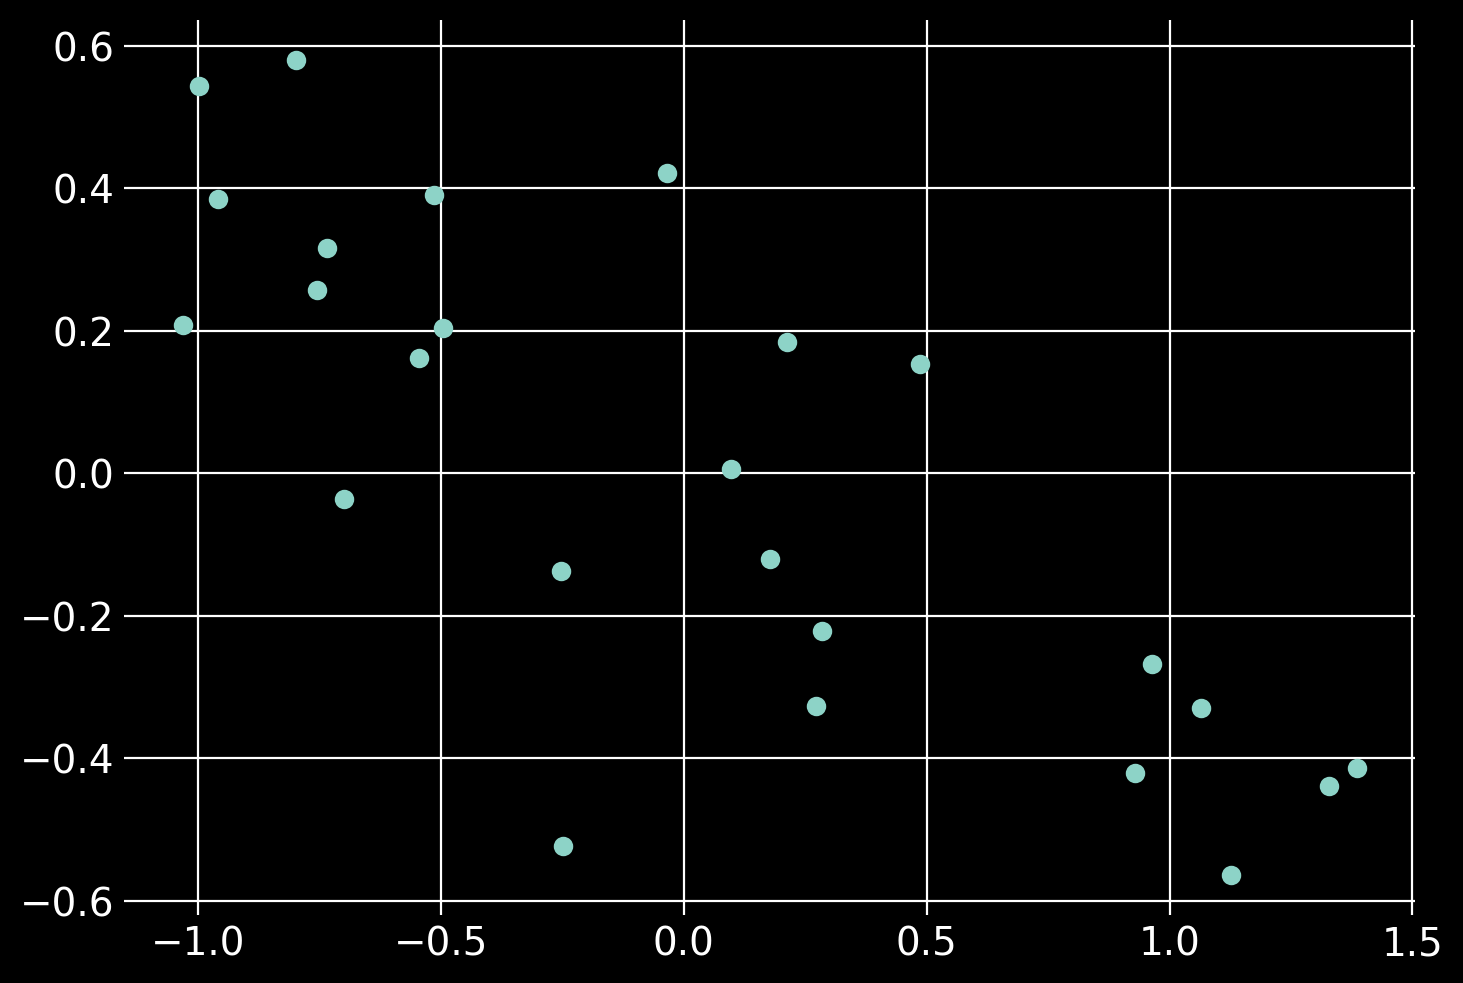

In [197]:
## effect of general giving and receiving (on log-odds scale)
plt.scatter((post7['gr'].mean(0)[0,:]), 
            (post7['gr'].mean(0)[1,:]));

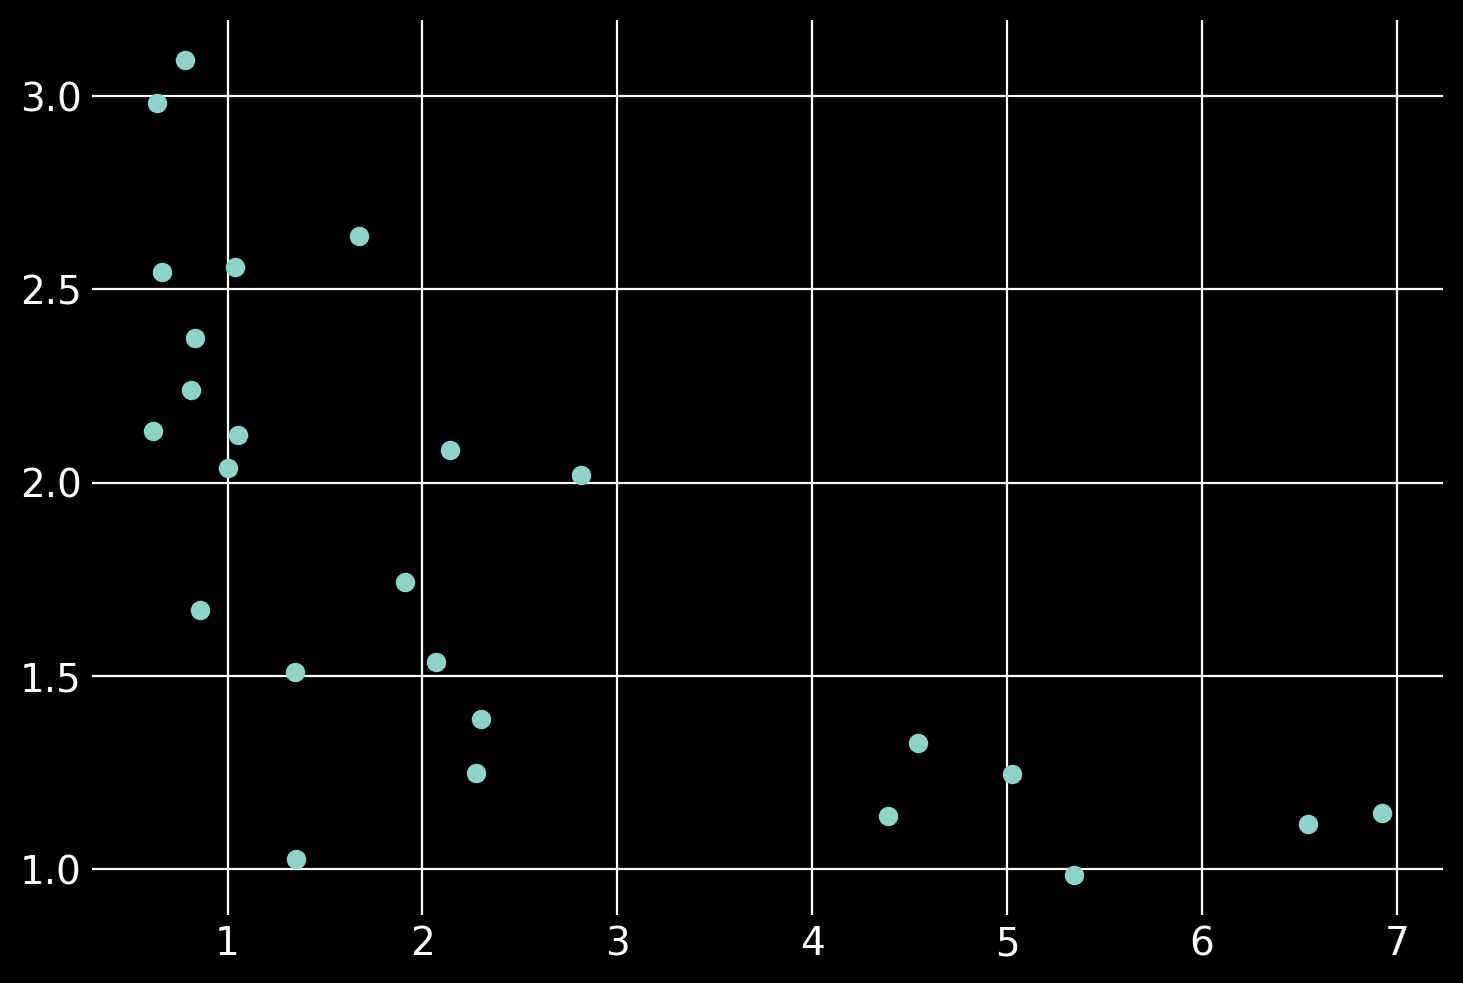

In [198]:
## general giving and receiving rate on outcome scale
## ignoring effect of reciprocity (which is assumed to have mean 0)
plt.scatter(np.exp(post7['a'].mean(0) + post7['gr'].mean(0)[0,:]), 
            np.exp(post7['a'].mean(0) + post7['gr'].mean(0)[1,:]));